In [1]:
import json
from pathlib import Path
import pprint
import requests

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

pp = pprint.PrettyPrinter(indent=4)

### Helper functions

In [2]:
def plot(img, cmap=None, fg_size=(10, 10)):
    plt.figure(figsize=fg_size)
    #plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.show()
    
def get_annotation(label):
    annotation = {}
    
    keys = list(label['Label'].keys())
    # line border
    line_borders = []
    for line in label['Label'][keys[0]]:
        line_pts = []
        for p in line['geometry']:
            line_pts.append([p['x'], p['y']])
        line_borders.append(line_pts)
    
    #side text
    side_text = []
    if len(keys) > 1 and label['Label'].get(keys[1], 0):
        for line in label['Label'][keys[1]]:
            for p in line['geometry']:
                side_text.append([p['x'], p['y']])
    
    annotation['line-border'] = line_borders
    annotation['side-text'] = side_text
    
    return annotation

### Test the quality of annotations

In [3]:
def draw_annotate(label):
    # check whether label is skipped
    if isinstance(label['Label'], str): return 'Lable skiped'
    
    # read image and if not exits download
    img_url = label['Labeled Data']
    proj_dir, img_fn = img_url.split('/')[-1].split('%2F')
    proj_dir = Path(proj_dir)
    proj_dir.mkdir(parents=True, exist_ok=True)
    img_path = Path('data/lb') / proj_dir / img_fn
    if not img_path.is_file():
        response = requests.get(img_url)
        img_path.write_bytes(response.content)
    img = cv2.imread(str(img_path))
    
    # read annotations
    anno = get_annotation(label)
    # pp.pprint(anno['line-border'][0])
    
    # draw annotation
    for line in anno['line-border']:
        pts = np.array(line)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img, [pts], False, (255,0,0))
    
    if anno['side-text']:
        pts = np.array(anno['side-text'])
        cv2.polylines(img,[pts],True,(0,0,255), -1)
        #cv2.fillPoly(img,[pts], (0,0,255))
    
    plot(img, cmap='gray')

In [4]:
labels = { 
    'a_Dhondup': Path('data/lb/01/a-Dhondup_01.json')
}

In [5]:
label_a_Dhondup = json.loads(labels['a_Dhondup'].read_text())

In [ ]:
label_a_Dhondup

In [ ]:
draw_annotate(label_a_Dhondup[5])

## Create dataset for line Segmentation

In [3]:
def download_img(label, prefix, data_dir):
    if isinstance(label['Label'], str): return ''

#     images_dir = data_dir/'images'
    images_dir = data_dir
    
    images_dir.mkdir(parents=True, exist_ok=True)
    
    img_url = label['Labeled Data']
    url_img_fn = img_url.split('/')[-1].split('%2F')[-1]
    infix, surfix = url_img_fn.split('.')
    img_fn = '{}_P{:03d}.{}'.format(prefix, int(infix.split('-')[-1]), surfix)
    img_path = images_dir/img_fn
    
    if not img_path.is_file():
        response = requests.get(img_url)
        img_path.write_bytes(response.content)
    
    return img_path
       

def combibe_masks(masks):
    # Correct the masks and combine
    mask = np.zeros((masks[0].shape), dtype=np.uint8)
    n = len(masks)
    for i in range(n):
        masks[i][masks[i] > 0] = i+1
        mask += masks[i]
    #zero out all the elements > num of classes
    mask[mask > n] = 0
    return mask
    
    
def split(img, mask, n):
    imgs, masks = [], []
    offset = img.shape[1] // n
    start, end = 0, offset
    for i in range(n):
        imgs.append(img[:, start:end])
        masks.append(mask[:, start:end])
        start, end = end, end+offset
    return imgs, masks


def create_label(anno, img_path):
    img = cv2.imread(str(img_path))
    mask = np.zeros((img.shape[:-1]), dtype=np.uint8)
    
    #create mask
    for line in anno['line-border']:
        pts = np.array(line)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(mask, [pts], False, 1, 2, 4)
    
    if anno['side-text']:
        pts = np.array(anno['side-text'])
        cv2.fillPoly(mask, [pts], 2, 4)

    # resize both image and mask
    img = cv2.resize(img, (2460, 500))
    mask = cv2.resize(mask, (2460, 500))
    
    # split mask and image into 3
    imgs, masks = split(img, mask, 3)

    # Delete the full image and save splited images and masks
    data_dir = (img_path.parent).parent
    fn = img_path.name
    prefix, surfix = fn.split('.')
    img_path.unlink()
    images_dir = data_dir/'images'
    labels_dir = data_dir/'labels'
    surfix = 'png'
    for i in range(len(imgs)):
        cv2.imwrite(str(images_dir/"{}_{:03d}.{}".format(prefix, i+1, surfix)), imgs[i])
        cv2.imwrite(str(labels_dir/"{}_{:03d}_P.{}".format(prefix, i+1, surfix)), masks[i])

    
def create_dataset(fn):
    data_dir = Path('data/lb/pecha/')
    
    labels = json.loads(fn.read_text())
    for label in tqdm(labels):
        img_path = download_img(label, fn.name.split('.')[0], data_dir)
        if not img_path: continue
        anno = get_annotation(label)
        create_label(anno, img_path)

In [ ]:
path = Path('data/lb/02')
fns = [o for o in path.iterdir() if o.name.endswith('.json')] 
for fn in tqdm(fns):
    create_dataset(fn)

create validation set

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
test_fn = 'a-Dhondup_01_P007_001.png'
'_'.join(test_fn.split('_')[:-1])

'a-Dhondup_01_P007'

In [8]:
img_fns = ['_'.join(fn.name.split('_')[:-1]) for fn in Path('data/lb/pecha/images/').iterdir()]
img_fns = list(set(img_fns))
train, valid = train_test_split(img_fns, test_size=0.20, random_state=42)
len(img_fns), len(train), len(valid)

(543, 434, 109)

In [9]:
valid[:5]

['c-Dhondup_02_P039',
 'c-Dhondup_02_P035',
 'g-lobsang_01_P787',
 'e-lobsang_01_P036',
 'd-lobsang_01_P089']

In [10]:
all_valid = []
for fn in valid:
    for i in range(3):
        all_valid.append('{}_{:03d}.png'.format(fn, i+1))

In [11]:
all_valid[:5]

['c-Dhondup_02_P039_001.png',
 'c-Dhondup_02_P039_002.png',
 'c-Dhondup_02_P039_003.png',
 'c-Dhondup_02_P035_001.png',
 'c-Dhondup_02_P035_002.png']

In [13]:
# save into valid.txt
valid_txt = Path('data/lb/pecha/valid.txt')
valid_txt.write_text('\n'.join(all_valid))

8471

Check for the mask

In [14]:
img = cv2.imread('data/lb/pecha/images/h-Dhondup_01_P012_001.png')
mask = cv2.imread('data/lb/pecha/labels/h-Dhondup_01_P012_001_P.png', 0)
img.shape, mask.shape

((500, 820, 3), (500, 820))

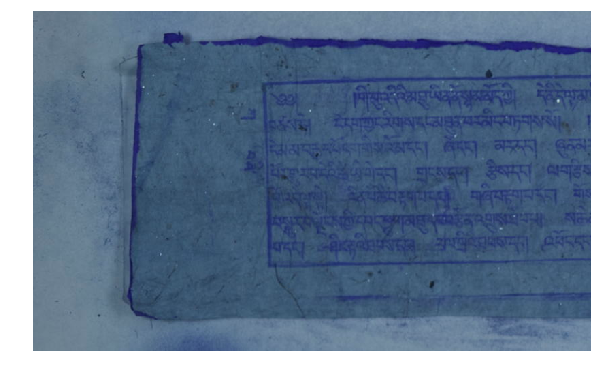

In [15]:
plot(img)

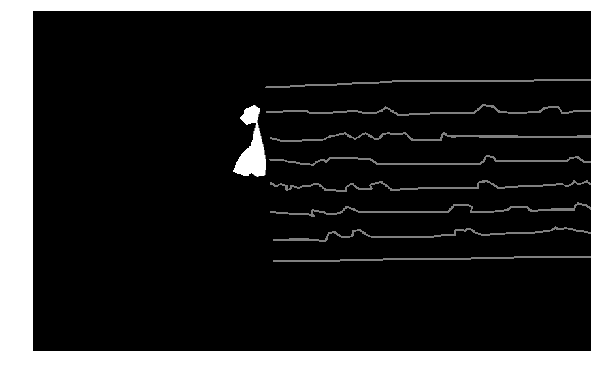

In [16]:
plot(mask, cmap='gray')

In [17]:
mask.min(), mask.max()

(0, 2)

In [18]:
print(len(mask[mask >= 0]))
print(len(mask[mask == 0]))
print(len(mask[mask == 1]))
print(len(mask[mask == 2]))
print(len(mask[mask > 2]))

410000
395501
11993
2506
0


### Notes
Intermediate storage for Mask
   - Do not use `JPEG`, it's a lossy format and values may differ when you subsequently read them back.
   - Use `PNG`, it's is a lossless format.

## Export to Transkribus

1. Get lb annotations
1. Create `text-region`, `line` and `base-line` from lb `line-border` annotations.
1. Create XML file for Transkribus

In [6]:
def test_plot(x, img_path, closed=True, color=(255, 0, 0)):
    img = cv2.imread(str(img_path))
    for line in x:
        pts = np.array(line)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img, [pts], closed, color)
    
    plot(img, fg_size=(50, 50))

In [4]:
#import pdb

def get_max_y(line):
    return max(line, key=lambda x: x[1])[1]

def get_avg_y(line):
    y_total = 0
    for p in line:
        y_total += p[1]
    return y_total // len(line)

def classify_line_borders(lines, y_th=25):
    #sort point of a line from left to right
    for line in lines:
        line.sort(key=lambda x: x[0])
        
    # Then classify the lines
    line_borders = []
    i = 0
    while i < len(lines):
        seg_lines = lines[i]
        while i < len(lines) - 1 and abs(get_avg_y(seg_lines) - get_avg_y(lines[i+1])) <= y_th:
            seg_lines.extend(lines[i+1])
            i +=1
        line_borders.append(seg_lines)
        i += 1
            
    return line_borders


def create_text_region(line_border):
    first_line = line_border[0][:]
    last_line = line_border[-1][:]
    
    start_point = first_line.pop(0)
    last_line.insert(0, start_point)
    last_line.extend(reversed(first_line))
    return last_line


def create_line(line_border):
    boxes = []
    i = 0
    while i < len(line_border) - 1:
#         pdb.set_trace()
        box = create_text_region([line_border[i], line_border[i+1]])
        boxes.append(box)
        i += 1
    return boxes

def create_base_line(line_border):
    pass


# #test
# lines = [
#     [[253, 328], [266, 328], [276, 334], [288, 330], [298, 328], [314, 330], [332, 332], [342, 333], [365, 335], [393, 335], [404, 334], [415, 335], [423, 335], [422, 329], [430, 328], [439, 329], [447, 337], [457, 339], [471, 335], [473, 328], [483, 326], [490, 330], [496, 328], [507, 329], [512, 329], [520, 333], [531, 335], [541, 334], [554, 334], [578, 334], [586, 332], [592, 326], [597, 325], [604, 331], [625, 332], [646, 332], [667, 333], [704, 332], [699, 328], [704, 324], [714, 325], [723, 325], [729, 330], [752, 331], [766, 331], [801, 331], [817, 331], [814, 322], [823, 319], [834, 323], [841, 328], [863, 329], [953, 330], [952, 325], [958, 321], [965, 319], [976, 324], [990, 327], [1004, 329], [1002, 323], [1008, 320], [1015, 321], [1023, 320], [1031, 324], [1045, 327], [1045, 320], [1053, 318], [1062, 318], [1072, 318], [1077, 325], [1103, 325], [1107, 317], [1112, 315], [1120, 319], [1128, 318], [1129, 326], [1138, 327], [1140, 321], [1149, 316], [1158, 316], [1171, 322], [1191, 326], [1215, 326], [1217, 317], [1226, 313], [1236, 316], [1242, 322], [1258, 322], [1266, 323], [1266, 317], [1275, 314], [1287, 316], [1295, 322], [1312, 324], [1332, 324], [1333, 316], [1345, 312], [1358, 312], [1360, 320], [1365, 325], [1381, 325], [1392, 322], [1415, 323], [1429, 321], [1430, 315], [1439, 313], [1459, 312], [1469, 319], [1493, 321], [1515, 321], [1527, 320], [1541, 319], [1541, 312], [1551, 310], [1558, 312], [1565, 311], [1576, 312], [1585, 319], [1604, 320], [1620, 320], [1627, 319], [1628, 310], [1637, 310], [1651, 312], [1650, 319], [1672, 317], [1694, 317], [1699, 311], [1712, 316], [1737, 316], [1771, 317], [1827, 316], [1839, 315], [1842, 305], [1846, 304], [1857, 307], [1867, 314], [1893, 315], [1893, 307], [1903, 304], [1922, 306], [1926, 314], [1953, 313], [1970, 313], [1964, 306], [1972, 303], [1988, 306], [2010, 311], [2027, 312], [2044, 311], [2057, 310], [2058, 303], [2069, 301], [2081, 303], [2090, 310], [2112, 311], [2119, 306], [2132, 302], [2150, 305], [2158, 306]],
    
#     [[259, 363], [280, 363], [300, 365], [329, 368], [343, 361], [354, 364], [369, 371], [390, 372], [397, 363], [415, 363], [428, 365], [439, 373], [449, 363], [465, 355], [475, 366], [494, 371], [505, 370], [509, 361], [524, 362], [540, 369], [556, 370], [556, 363], [564, 361], [577, 360], [592, 364], [602, 361], [618, 360], [625, 366], [641, 368], [649, 362], [656, 361], [668, 362], [678, 360], [690, 359], [706, 359], [719, 366], [739, 364]],
#     [[738, 364], [754, 364], [782, 364], [781, 356], [789, 355], [798, 361], [816, 364], [826, 360], [834, 354], [850, 355], [860, 355], [868, 363], [886, 363], [912, 362], [933, 362], [945, 358], [957, 354], [971, 361], [989, 361], [1023, 361], [1051, 361], [1081, 361], [1084, 352], [1101, 349], [1110, 358], [1145, 362], [1163, 360], [1167, 353], [1179, 355], [1191, 354], [1203, 357], [1228, 360], [1268, 359], [1288, 359], [1307, 356], [1313, 348], [1328, 349], [1346, 354], [1371, 357], [1372, 347], [1386, 347], [1396, 349], [1405, 355], [1423, 356], [1425, 349], [1435, 347], [1445, 350], [1454, 350], [1465, 352], [1471, 348], [1486, 347], [1496, 352], [1515, 355], [1537, 352], [1567, 352], [1582, 352], [1586, 344], [1600, 346], [1613, 346], [1623, 343], [1640, 342], [1652, 344], [1672, 347], [1727, 346], [1769, 347], [1777, 339], [1792, 338]],
#     [[1790, 339], [1799, 346], [1820, 346], [1823, 339], [1837, 341], [1851, 339], [1867, 347], [1883, 346], [1888, 339], [1900, 337], [1916, 340], [1938, 346], [1959, 345], [1959, 338], [1974, 338], [1987, 338], [1996, 345], [2020, 347], [2034, 346], [2050, 343], [2055, 337], [2062, 334], [2071, 336], [2079, 341], [2088, 345], [2113, 345], [2109, 338], [2116, 335], [2126, 338], [2135, 344], [2156, 346]],
    
#     [[258, 403], [303, 407], [337, 406], [395, 405], [437, 404], [462, 405], [499, 403], [544, 405], [589, 403], [630, 403], [665, 403], [712, 401], [761, 402], [788, 399], [827, 396], [868, 398], [905, 399], [946, 396], [997, 396], [1039, 395], [1077, 393], [1113, 392], [1155, 394], [1193, 392], [1231, 392], [1277, 390], [1321, 389], [1350, 391], [1389, 391], [1414, 387], [1463, 386], [1521, 387], [1570, 384], [1617, 384], [1661, 383], [1698, 383], [1752, 383], [1797, 381], [1840, 383], [1879, 381], [1938, 380], [1976, 379], [2004, 380], [2031, 379], [2076, 377], [2110, 377], [2142, 379], [2159, 378]]
# ]

lines = [
    [[248, 219], [271, 221], [302, 223], [353, 222], [360, 216], [371, 216], [380, 222], [395, 221], [399, 217], [406, 215], [412, 221], [425, 218], [431, 219], [433, 224], [444, 225], [450, 222], [462, 215], [469, 216], [479, 223], [535, 225], [606, 227], [618, 225], [623, 219], [628, 218], [637, 221], [644, 227], [665, 229], [698, 225], [703, 220], [711, 218], [721, 224], [728, 227], [740, 229], [747, 227], [751, 223], [758, 220], [761, 222], [774, 229], [784, 229], [793, 232], [799, 225], [802, 221], [812, 222], [817, 225], [830, 220], [831, 229], [834, 224], [854, 229], [858, 224], [865, 221], [875, 221], [880, 226], [884, 233], [923, 229], [931, 224], [939, 227], [947, 226], [957, 226], [958, 230], [972, 235], [1018, 234], [1024, 226], [1027, 226], [1035, 233], [1046, 232], [1055, 229], [1062, 226], [1068, 231], [1074, 228], [1080, 233], [1081, 237], [1128, 236], [1136, 232], [1143, 228], [1150, 233], [1163, 228], [1169, 232], [1170, 236], [1206, 238], [1245, 241], [1283, 232], [1288, 229], [1295, 233], [1311, 229], [1313, 233], [1318, 237], [1336, 237], [1365, 237], [1401, 238], [1414, 240], [1418, 238], [1419, 230], [1427, 228], [1437, 233], [1444, 237], [1478, 237], [1492, 240], [1501, 238], [1514, 239], [1530, 242], [1549, 240], [1576, 240], [1619, 239], [1624, 234], [1633, 231], [1640, 233], [1647, 240], [1658, 242], [1684, 241], [1692, 241], [1704, 243], [1710, 241], [1738, 237], [1746, 232], [1754, 232], [1764, 238], [1790, 241], [1838, 244], [1867, 245], [1869, 241], [1874, 234], [1876, 235], [1884, 241], [1901, 237], [1907, 233], [1915, 240], [1922, 237], [1928, 234], [1935, 235], [1941, 241], [1948, 244], [1961, 243], [1973, 244], [2045, 244], [2083, 243], [2089, 237], [2099, 236], [2110, 242], [2129, 240], [2136, 236], [2144, 240], [2163, 235], [2168, 236], [2171, 244], [2194, 244], [2197, 237], [2202, 235], [2211, 238], [2218, 243], [2264, 244], [2283, 244], [2292, 244], [246, 252], [284, 253], [301, 254], [312, 252], [317, 250], [329, 256], [359, 260]],

    [[246, 252], [284, 253], [301, 254], [312, 252], [317, 250], [329, 256], [359, 260]]
]

# classify_line_borders(lines)

In [17]:
import xml.etree.ElementTree as ET

def to_xml_coord(line):
    xml_coord = ''
    for point in line:
        xml_coord += ' ' + '{},{}'.format(point[0], point[1])
    return xml_coord[1:]

def create_xml(anno, img_path, export_dir):
    line_border = classify_line_borders(anno['line-border'])
    text_region = create_text_region(line_border)
    lines = create_line(line_border)
#     base_lines = create_base_line(line_border)

#     test_plot([text_region], img_path, color=(255, 255, 0))
#     test_plot(lines, img_path)

    # Create XML file
    tree = ET.parse(str(export_dir/'template.xml'))
    root = tree.getroot()

    page = root[0]
    w, h, _ = cv2.imread(str(img_path)).shape
    page.attrib['imageFilename'] = img_path.name
    page.attrib['imageWidth'] = str(w)
    page.attrib['imageHeight'] = str(h)

    tr = page[1]
    tr_coord = tr[0]
    tr_coord.attrib['points'] = to_xml_coord(text_region)

    # Remove extra textline
    n_extra = 7 - len(lines)
    if n_extra > 0:
        for _ in range(n_extra):
            tr.remove(tr[-1])

    for textline, line in zip(tr[1:], lines):
        textline[0].attrib['points'] = to_xml_coord(line)

    # Save to XML file
    page_dir = export_dir/'page'
    page_dir.mkdir(parents=True, exist_ok=True)
    xml_fn = page_dir/'{}.xml'.format(img_path.stem)
    tree.write(str(xml_fn), default_namespace=None)

    # Postprocess the XML, remove prefix
    xml_text = xml_fn.read_text()
    final_xml_text = xml_text.replace('ns0:', '')
    final_xml_text = final_xml_text.replace('xmlns:ns0', 'xmlns')
    final_xml_text = '<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n' + final_xml_text
    xml_fn.write_text(final_xml_text)

            
#test
#to_xml_coord(lines[0])

In [18]:
def export_transkribus(fn, export_dir):
    labels = json.loads(fn.read_text())
    for label in tqdm(labels):
        img_path = download_img(label, fn.name.split('.')[0], export_dir)
        if not img_path: continue
        anno = get_annotation(label)
        create_xml(anno, img_path, export_dir)

In [19]:
path = Path('data/lb')
export_dir = Path('data/transkribus/dergey-kangyur/')

In [20]:
fns = [o for o in path.iterdir() if o.name.endswith('.json')] 
for fn in tqdm(fns):
    export_transkribus(fn, export_dir)

[[251, 113], [268, 112], [276, 109], [286, 113], [293, 110], [305, 110], [310, 113], [330, 113], [337, 109], [348, 110], [354, 113], [387, 114], [393, 111], [403, 111], [408, 115], [567, 116], [570, 111], [577, 109], [585, 111], [591, 115], [612, 115], [615, 111], [623, 111], [629, 115], [654, 116], [660, 111], [668, 109], [676, 113], [685, 113], [691, 111], [699, 111], [710, 114], [721, 114], [725, 111], [732, 110], [742, 113], [750, 115], [761, 115], [768, 111], [775, 114], [781, 116], [842, 115], [858, 115], [866, 114], [874, 117], [970, 119], [977, 114], [988, 115], [995, 119], [1006, 118], [1011, 116], [1020, 117], [1027, 119], [1033, 116], [1040, 116], [1052, 120], [1130, 123], [1147, 122], [1154, 121], [1162, 122], [1172, 120], [1178, 120], [1186, 119], [1192, 121], [1203, 120], [1215, 123], [1221, 120], [1231, 120], [1241, 123], [1272, 124], [1280, 119], [1288, 123], [1294, 121], [1311, 120], [1317, 123], [1367, 125], [1376, 122], [1380, 125], [1391, 121], [1400, 122], [1410, 1

## Extract the individual line from each page using annotations

In [5]:
def is_box(line):
    prev_x = line[0][0]
    for p in line[1:]:
        if abs(p[0] - prev_x) > 800: 
            return False
        prev_x = p[0]
    return True
   
# test
# [2283, 244], [2292, 244], [246, 252], [284, 253], [301, 254]
not_box_01 = [[247, 189], [248, 219], [271, 221], [302, 223], [353, 222], [360, 216], [371, 216], [380, 222], [395, 221], [399, 217], [406, 215], [412, 221], [425, 218], [431, 219], [433, 224], [444, 225], [450, 222], [462, 215], [469, 216], [479, 223], [535, 225], [606, 227], [618, 225], [623, 219], [628, 218], [637, 221], [644, 227], [665, 229], [698, 225], [703, 220], [711, 218], [721, 224], [728, 227], [740, 229], [747, 227], [751, 223], [758, 220], [761, 222], [774, 229], [784, 229], [793, 232], [799, 225], [802, 221], [812, 222], [817, 225], [830, 220], [831, 229], [834, 224], [854, 229], [858, 224], [865, 221], [875, 221], [880, 226], [884, 233], [923, 229], [931, 224], [939, 227], [947, 226], [957, 226], [958, 230], [972, 235], [1018, 234], [1024, 226], [1027, 226], [1035, 233], [1046, 232], [1055, 229], [1062, 226], [1068, 231], [1074, 228], [1080, 233], [1081, 237], [1128, 236], [1136, 232], [1143, 228], [1150, 233], [1163, 228], [1169, 232], [1170, 236], [1206, 238], [1245, 241], [1283, 232], [1288, 229], [1295, 233], [1311, 229], [1313, 233], [1318, 237], [1336, 237], [1365, 237], [1401, 238], [1414, 240], [1418, 238], [1419, 230], [1427, 228], [1437, 233], [1444, 237], [1478, 237], [1492, 240], [1501, 238], [1514, 239], [1530, 242], [1549, 240], [1576, 240], [1619, 239], [1624, 234], [1633, 231], [1640, 233], [1647, 240], [1658, 242], [1684, 241], [1692, 241], [1704, 243], [1710, 241], [1738, 237], [1746, 232], [1754, 232], [1764, 238], [1790, 241], [1838, 244], [1867, 245], [1869, 241], [1874, 234], [1876, 235], [1884, 241], [1901, 237], [1907, 233], [1915, 240], [1922, 237], [1928, 234], [1935, 235], [1941, 241], [1948, 244], [1961, 243], [1973, 244], [2045, 244], [2083, 243], [2089, 237], [2099, 236], [2110, 242], [2129, 240], [2136, 236], [2144, 240], [2163, 235], [2168, 236], [2171, 244], [2194, 244], [2197, 237], [2202, 235], [2211, 238], [2218, 243], [2264, 244], [2283, 244], [2292, 244], [246, 252], [284, 253], [301, 254], [312, 252], [317, 250], [329, 256], [359, 260], [2293, 200], [2280, 200], [2273, 207], [2266, 202], [2262, 207], [2256, 208], [2247, 207], [2235, 202], [2225, 199], [2220, 203], [2215, 210], [2184, 207], [2141, 208], [2124, 208], [2117, 199], [2114, 208], [2112, 198], [2110, 209], [2084, 206], [2057, 206], [2013, 207], [1996, 207], [1989, 199], [1984, 197], [1977, 197], [1965, 200], [1931, 206], [1919, 207], [1912, 206], [1863, 205], [1854, 208], [1849, 208], [1846, 201], [1841, 197], [1835, 196], [1828, 204], [1823, 202], [1816, 197], [1810, 200], [1801, 196], [1794, 201], [1760, 205], [1749, 206], [1736, 204], [1703, 200], [1694, 194], [1688, 196], [1681, 197], [1675, 199], [1671, 203], [1667, 201], [1658, 199], [1650, 203], [1629, 203], [1620, 199], [1615, 197], [1611, 193], [1604, 194], [1597, 197], [1590, 199], [1582, 196], [1579, 200], [1557, 202], [1494, 202], [1484, 199], [1475, 196], [1466, 193], [1456, 200], [1443, 202], [1418, 205], [1407, 200], [1401, 196], [1390, 196], [1385, 197], [1375, 193], [1373, 198], [1369, 202], [1322, 200], [1310, 202], [1301, 201], [1255, 199], [1219, 197], [1209, 193], [1203, 194], [1192, 197], [1183, 201], [1174, 199], [1168, 197], [1162, 200], [1152, 199], [1145, 195], [1141, 191], [1136, 192], [1129, 197], [1077, 195], [1066, 188], [1052, 191], [1045, 196], [1040, 191], [1036, 192], [1033, 197], [1027, 198], [1014, 197], [990, 199], [981, 196], [975, 197], [962, 197], [954, 195], [949, 197], [916, 195], [837, 195], [815, 195], [809, 194], [806, 189], [799, 184], [794, 184], [792, 192], [771, 192], [723, 194], [702, 194], [685, 192], [664, 188], [656, 184], [645, 181], [635, 186], [629, 182], [621, 187], [613, 181], [602, 182], [599, 190], [577, 191], [561, 185], [555, 179], [550, 181], [542, 184], [537, 185], [526, 182], [524, 191], [503, 192], [497, 190], [486, 184], [479, 190], [468, 187], [396, 183], [345, 189], [289, 189], [266, 189]]

not_box_02 = [[253, 111], [1445, 374], [1453, 376], [1459, 380], [1465, 384], [1473, 387], [1479, 383], [1482, 379], [1486, 376], [1497, 376], [1510, 376], [1523, 376], [1535, 376], [1543, 376], [1551, 376], [1557, 373], [1564, 373], [1571, 380], [1580, 379], [1586, 378], [1595, 376], [1604, 375], [1613, 373], [1618, 374], [1626, 379], [1633, 382], [1640, 380], [1646, 383], [1659, 381], [1664, 379], [1673, 376], [1682, 375], [1692, 376], [1701, 377], [1709, 380], [1716, 375], [1719, 371], [1729, 375], [1738, 377], [1741, 383], [1750, 383], [1756, 381], [1760, 375], [1765, 374], [1769, 379], [1774, 384], [1782, 384], [1786, 383], [1795, 383], [1799, 378], [1807, 379], [1812, 385], [1818, 386], [1820, 380], [1824, 376], [1836, 375], [1847, 375], [1858, 381], [1869, 386], [1882, 383], [1894, 380], [1904, 386], [1907, 381], [1911, 376], [1924, 374], [1936, 374], [1954, 376], [1960, 384], [1967, 385], [1980, 380], [1996, 374], [2023, 374], [2049, 378], [2065, 378], [2081, 377], [2091, 374], [2103, 376], [2110, 382], [2124, 385], [2126, 382], [2132, 379], [2148, 379], [2161, 385], [2167, 385], [2172, 377], [2182, 376], [2188, 382], [2197, 383], [2203, 381], [2211, 379], [2228, 379], [2266, 378], [2293, 376], [242, 368], [255, 369], [270, 370], [301, 372], [337, 373], [358, 372], [368, 373], [376, 375], [387, 370], [398, 367], [409, 368], [416, 372], [427, 374], [435, 370], [442, 369], [450, 370], [457, 375], [464, 378], [471, 378], [478, 372], [484, 368], [499, 368], [517, 370], [528, 369], [539, 366], [555, 365], [562, 368], [566, 374], [571, 378], [577, 377], [580, 369], [589, 366], [599, 368], [611, 372], [621, 374], [629, 376], [641, 376], [648, 377], [651, 369], [654, 373], [663, 373], [670, 368], [681, 370], [694, 370], [700, 373], [710, 374], [714, 370], [720, 369], [729, 371], [733, 375], [742, 379], [752, 379], [758, 371], [764, 370], [770, 376], [776, 381], [780, 378], [787, 377], [793, 375], [799, 372], [805, 380], [812, 383], [818, 379], [820, 372], [833, 370], [847, 372], [857, 374], [862, 381], [868, 383], [873, 380], [888, 379], [908, 380], [910, 384], [918, 384], [925, 375], [939, 372], [949, 374], [956, 378], [965, 383], [971, 382], [976, 374], [985, 374], [996, 371], [1008, 371], [1027, 371], [1043, 371], [1060, 373], [1076, 372], [1089, 371], [1104, 373], [1112, 378], [1118, 385], [1127, 378], [1127, 384], [1130, 370], [1145, 372], [1156, 374], [1159, 380], [1165, 384], [1168, 379], [1172, 373], [1181, 373], [1188, 374], [1191, 379], [1199, 381], [1207, 380], [1212, 376], [1216, 376], [1220, 383], [1230, 387], [1231, 379], [1233, 373], [1240, 375], [1247, 372], [1252, 370], [1256, 377], [1262, 385], [1268, 379], [1269, 372], [1269, 384], [1277, 376], [1285, 380], [1293, 385], [1299, 381], [1299, 385], [1301, 376], [1311, 374], [1320, 374], [1326, 374], [1333, 378], [1338, 382], [1344, 382], [1357, 382], [1362, 377], [1368, 377], [1376, 382], [1384, 384], [1389, 378], [1395, 376], [1408, 379], [1420, 383], [1431, 382], [1439, 377], [1445, 374], [2289, 123], [2243, 123], [2234, 119], [2224, 116], [2215, 118], [2213, 124], [2188, 122], [2182, 118], [2170, 118], [2164, 120], [2155, 118], [2149, 119], [2146, 123], [2071, 123], [2066, 119], [2053, 118], [2045, 120], [2040, 125], [1869, 125], [1860, 123], [1853, 120], [1847, 118], [1840, 120], [1836, 123], [1754, 124], [1748, 119], [1739, 118], [1731, 119], [1727, 126], [1615, 125], [1604, 121], [1595, 118], [1586, 118], [1583, 123], [1579, 118], [1571, 117], [1566, 119], [1564, 125], [1530, 124], [1491, 124], [1466, 126], [1439, 126], [1424, 125], [1420, 122], [1410, 121], [1401, 123], [1395, 121], [1389, 121], [1383, 123], [1347, 124], [1339, 121], [1331, 118], [1324, 116], [1317, 121], [1312, 123], [1306, 119], [1296, 117], [1287, 117], [1280, 119], [1274, 116], [1268, 121], [1259, 120], [1255, 117], [1247, 117], [1239, 121], [1235, 117], [1227, 122], [1218, 123], [1203, 123], [1194, 119], [1190, 117], [1181, 118], [1172, 120], [1163, 117], [1159, 123], [1141, 123], [1123, 121], [1116, 116], [1108, 114], [1097, 115], [1088, 119], [1079, 119], [1075, 116], [1070, 114], [1059, 115], [1056, 120], [947, 119], [732, 115], [724, 112], [718, 108], [707, 109], [704, 113], [694, 108], [683, 110], [675, 115], [651, 113], [644, 110], [635, 107], [626, 110], [621, 113], [613, 110], [603, 108], [589, 108], [579, 108], [571, 108], [561, 108], [552, 108], [546, 112], [478, 113], [470, 110], [462, 105], [452, 106], [448, 113]]

box_01 = [[247, 146], [247, 189], [266, 189], [289, 189], [345, 189], [396, 183], [468, 187], [479, 190], [486, 184], [497, 190], [503, 192], [524, 191], [526, 182], [537, 185], [542, 184], [550, 181], [555, 179], [561, 185], [577, 191], [599, 190], [602, 182], [613, 181], [621, 187], [629, 182], [635, 186], [645, 181], [656, 184], [664, 188], [685, 192], [702, 194], [723, 194], [771, 192], [792, 192], [794, 184], [799, 184], [806, 189], [809, 194], [815, 195], [837, 195], [916, 195], [949, 197], [954, 195], [962, 197], [975, 197], [981, 196], [990, 199], [1014, 197], [1027, 198], [1033, 197], [1036, 192], [1040, 191], [1045, 196], [1052, 191], [1066, 188], [1077, 195], [1129, 197], [1136, 192], [1141, 191], [1145, 195], [1152, 199], [1162, 200], [1168, 197], [1174, 199], [1183, 201], [1192, 197], [1203, 194], [1209, 193], [1219, 197], [1255, 199], [1301, 201], [1310, 202], [1322, 200], [1369, 202], [1373, 198], [1375, 193], [1385, 197], [1390, 196], [1401, 196], [1407, 200], [1418, 205], [1443, 202], [1456, 200], [1466, 193], [1475, 196], [1484, 199], [1494, 202], [1557, 202], [1579, 200], [1582, 196], [1590, 199], [1597, 197], [1604, 194], [1611, 193], [1615, 197], [1620, 199], [1629, 203], [1650, 203], [1658, 199], [1667, 201], [1671, 203], [1675, 199], [1681, 197], [1688, 196], [1694, 194], [1703, 200], [1736, 204], [1749, 206], [1760, 205], [1794, 201], [1801, 196], [1810, 200], [1816, 197], [1823, 202], [1828, 204], [1835, 196], [1841, 197], [1846, 201], [1849, 208], [1854, 208], [1863, 205], [1912, 206], [1919, 207], [1931, 206], [1965, 200], [1977, 197], [1984, 197], [1989, 199], [1996, 207], [2013, 207], [2057, 206], [2084, 206], [2110, 209], [2112, 198], [2114, 208], [2117, 199], [2124, 208], [2141, 208], [2184, 207], [2215, 210], [2220, 203], [2225, 199], [2235, 202], [2247, 207], [2256, 208], [2262, 207], [2266, 202], [2273, 207], [2280, 200], [2293, 200], [2294, 170], [2286, 170], [2277, 167], [2267, 163], [2257, 163], [2245, 163], [2228, 166], [2220, 162], [2213, 166], [2157, 172], [2137, 170], [2118, 170], [2107, 173], [2100, 171], [2090, 165], [2082, 166], [2048, 168], [2039, 160], [2033, 161], [2030, 169], [2004, 168], [1990, 161], [1983, 165], [1966, 169], [1924, 169], [1917, 162], [1911, 163], [1906, 168], [1896, 170], [1886, 163], [1880, 160], [1870, 162], [1862, 166], [1833, 166], [1821, 157], [1814, 162], [1802, 167], [1776, 168], [1720, 168], [1703, 167], [1695, 170], [1685, 167], [1657, 166], [1616, 165], [1610, 160], [1601, 157], [1596, 158], [1591, 161], [1584, 157], [1572, 159], [1565, 155], [1560, 160], [1556, 165], [1537, 166], [1514, 166], [1468, 163], [1443, 165], [1433, 161], [1425, 159], [1419, 162], [1413, 156], [1405, 158], [1397, 160], [1387, 164], [1381, 166], [1366, 166], [1362, 159], [1356, 156], [1350, 163], [1331, 162], [1329, 158], [1322, 157], [1311, 159], [1302, 155], [1297, 159], [1276, 161], [1254, 164], [1242, 160], [1236, 163], [1229, 165], [1219, 163], [1217, 158], [1208, 160], [1203, 158], [1197, 159], [1175, 160], [1166, 155], [1159, 154], [1152, 154], [1146, 157], [1138, 153], [1130, 153], [1128, 163], [1118, 162], [1114, 159], [1110, 157], [1106, 156], [1100, 155], [1093, 153], [1084, 154], [1081, 159], [1067, 164], [1052, 163], [1042, 163], [1022, 163], [979, 160], [971, 154], [964, 150], [955, 152], [945, 150], [934, 150], [930, 153], [924, 155], [916, 152], [909, 150], [902, 150], [900, 156], [880, 157], [859, 156], [826, 154], [772, 154], [735, 153], [727, 148], [712, 153], [707, 148], [701, 147], [696, 151], [689, 148], [675, 151], [669, 147], [660, 150], [643, 152], [610, 154], [584, 154], [565, 154], [557, 147], [549, 144], [539, 149], [533, 151], [527, 150], [522, 145], [517, 145], [510, 148], [509, 156], [500, 155], [493, 151], [487, 147], [479, 145], [473, 145], [470, 148], [469, 155], [464, 152], [459, 148], [454, 147], [448, 148], [442, 151], [432, 152], [431, 146], [428, 144], [410, 151], [404, 145], [398, 145], [393, 149], [367, 153], [340, 152], [307, 151], [281, 151], [274, 146], [263, 140], [257, 142], [252, 146]]

box_02 = [[248, 187], [247, 213], [257, 212], [266, 213], [271, 217], [274, 220], [279, 222], [285, 223], [290, 225], [292, 219], [293, 224], [294, 215], [296, 213], [301, 214], [304, 216], [309, 218], [311, 224], [367, 225], [500, 227], [503, 220], [508, 215], [513, 212], [520, 214], [527, 219], [536, 226], [557, 227], [665, 228], [750, 228], [754, 222], [760, 219], [769, 220], [775, 226], [778, 230], [785, 232], [787, 229], [788, 224], [792, 222], [797, 223], [802, 226], [806, 222], [812, 220], [819, 220], [825, 224], [827, 229], [832, 233], [837, 236], [843, 234], [846, 231], [848, 226], [850, 221], [857, 222], [865, 225], [868, 228], [877, 225], [882, 229], [916, 231], [1035, 235], [1043, 224], [1050, 224], [1055, 229], [1059, 225], [1065, 225], [1070, 228], [1077, 232], [1083, 235], [1135, 235], [1140, 229], [1145, 226], [1151, 229], [1156, 234], [1164, 235], [1298, 236], [1302, 234], [1305, 228], [1311, 227], [1316, 229], [1320, 232], [1325, 235], [1404, 234], [1406, 230], [1408, 224], [1417, 225], [1420, 229], [1428, 234], [1438, 237], [1484, 235], [1509, 235], [1515, 229], [1522, 223], [1532, 226], [1540, 234], [1555, 236], [1615, 238], [1658, 237], [1686, 237], [1720, 237], [1724, 229], [1735, 226], [1744, 230], [1751, 237], [1831, 236], [1832, 231], [1837, 227], [1844, 230], [1848, 232], [1859, 232], [1867, 232], [1872, 236], [1877, 240], [1899, 239], [1906, 231], [1912, 228], [1919, 230], [1926, 233], [1931, 237], [1937, 239], [1985, 231], [1987, 236], [1987, 227], [1991, 225], [1997, 224], [2004, 229], [2013, 234], [2019, 238], [2047, 237], [2080, 235], [2178, 236], [2184, 238], [2187, 234], [2187, 228], [2193, 227], [2202, 229], [2208, 233], [2214, 234], [2225, 235], [2260, 233], [2292, 234], [2289, 196], [2265, 197], [2259, 191], [2253, 186], [2245, 188], [2242, 196], [2225, 199], [2062, 199], [2054, 191], [2033, 188], [2031, 195], [2028, 200], [2025, 196], [2022, 190], [2017, 190], [2014, 193], [2005, 194], [2000, 191], [1993, 193], [1985, 197], [1967, 199], [1951, 200], [1941, 196], [1927, 188], [1918, 190], [1914, 196], [1907, 199], [1831, 202], [1715, 202], [1686, 200], [1677, 192], [1668, 188], [1663, 193], [1655, 199], [1594, 201], [1538, 200], [1530, 195], [1520, 192], [1513, 193], [1507, 199], [1499, 200], [1345, 200], [1337, 199], [1331, 196], [1323, 192], [1317, 193], [1307, 192], [1300, 190], [1292, 189], [1279, 189], [1266, 189], [1254, 189], [1243, 191], [1237, 197], [1170, 199], [1165, 197], [1158, 189], [1150, 187], [1143, 191], [1137, 198], [1097, 198], [1021, 196], [1010, 188], [1001, 186], [994, 190], [988, 196], [856, 196], [819, 195], [811, 189], [803, 183], [797, 187], [790, 192], [700, 192], [695, 187], [688, 181], [682, 181], [674, 185], [664, 190], [642, 191], [599, 190], [536, 191], [532, 191], [520, 178], [512, 179], [505, 187], [497, 189], [492, 191], [383, 188], [376, 182], [369, 177], [360, 176], [355, 181], [350, 186], [328, 186], [324, 181], [318, 178], [313, 181], [304, 184], [296, 178], [290, 181], [283, 185]]

print(is_box(box_02))

True


In [6]:
def apply_mask(line, img):
    pts = np.array(line)
    
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
    
    ## (2) make mask
    pts = pts - pts.min(axis=0)
    mask = np.zeros((croped.shape[:2]), dtype=np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    
    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    
    return dst
    
#     print(croped.shape)
#     plot(croped, fg_size=(50, 50))
#     plot(dst, fg_size=(50, 50))
    
#     ## (4) add background
#     h, w, _ = croped.shape
#     croped_bg = bg[0:h, 0:w].copy()
#     mask_inv = cv2.bitwise_not(mask)
#     croped_bg = cv2.bitwise_and(croped_bg, croped_bg, mask=mask_inv)
#     dst2 = cv2.add(dst, croped_bg)
#     cv2.imwrite('data/google-lineseg/result.png', dst2)
    
#     plot(dst2, fg_size=(50, 50))

def extract_lines(anno, img_path, export_dir):
    line_border = classify_line_borders(anno['line-border'])
    lines = create_line(line_border)
    
    page = img_path.stem
    output_dir = export_dir/'lines'/page
    output_dir.mkdir(parents=True, exist_ok=True)
    
    img = cv2.imread(str(img_path))
    for i, line in enumerate(lines):
        if is_box(line):
#             test_plot([line], img_path)
            line_img = apply_mask(line, img)
            cv2.imwrite(f'{output_dir}/{i+1}.png', line_img)

#     test_plot([lines[1]], img_path)

In [7]:
def export_pecha_lines(fn, export_dir):
    labels = json.loads(fn.read_text())
    for label in tqdm(labels):
        img_path = download_img(label, fn.name.split('.')[0], export_dir)
        if not img_path: continue
        anno = get_annotation(label)
        extract_lines(anno, img_path, export_dir)

In [9]:
path = Path('data/lb')
export_dir = Path('data/google-lineseg')

In [11]:
fns = [o for o in path.iterdir() if o.name.endswith('.json')] 
for fn in tqdm(fns):
    export_pecha_lines(fn, export_dir)